# 3. Define calibration sections
The goal of this notebook is to show how you can define calibration sections. That means that we define certain parts of the fiber to a timeseries of temperature measurements. Here, we assume the temperature timeseries is already part of the `DataStore` object.

In [1]:
import os

from dtscalibration import read_silixa_files

In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'double_ended2')
ds = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    timezone_input_files='Europe/Amsterdam',
    file_ext='*.xml')

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
The measurement is double ended


First we have a look at which temperature timeseries are available for calibration. Therefore we access `ds.data_vars` and we find `probe1Temperature` and `probe2Temperature` that refer to the temperature measurement timeseries of the two probes attached to the Ultima.

Alternatively, we can access the `ds.timeseries_keys` property to list all timeseries that can be used for calibration.

['acquisitionTime', 'referenceTemperature', 'probe1Temperature', 'probe2Temperature', 'referenceProbeVoltage', 'probe1Voltage', 'probe2Voltage', 'userAcquisitionTimeFW', 'userAcquisitionTimeBW']


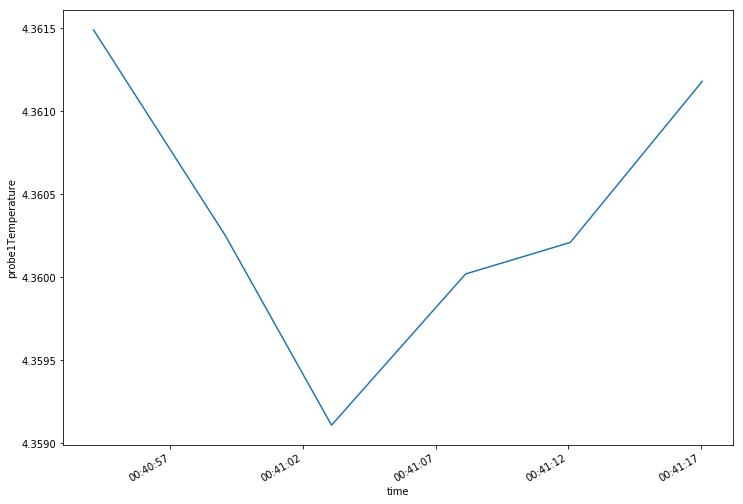

In [9]:
print(ds.timeseries_keys)    # list the available timeseeries
ds.probe1Temperature.plot(figsize=(12, 8));  # plot one of the timeseries

A calibration is needed to estimate temperature from Stokes and anti-Stokes measurements. There are three unknowns for a single ended calibration procedure $\gamma$, $C$, and $\alpha$. The parameters $\gamma$ and $\alpha$ remain constant over time, while $C$ may vary. 

At least two calibration sections of different temperatures are needed to perform a decent calibration procedure.

This setup has two baths, named 'cold' and 'warm'. Each bath has 2 sections. `probe1Temperature` is the temperature timeseries of the cold bath and `probe2Temperature` is the temperature timeseries of the warm bath.

| Name section | Name reference temperature time series | Number of sections | Location of sections (m) |
|--------------|:--------------------------------------:|:------------------:|:------------------------:|
| Cold bath    |            probe1Temperature           |          2         |   7.5-17.0; 70.0-80.0  |
| Warm bath    |            probe2Temperature           |          2         |  24.0-34.0; 85.0-95.0  |

Sections are defined in a dictionary with its keywords of the names of the reference temperature time series. Its values are lists of slice objects, where each slice object is a section.

Note that slice is part of the standard Python library and no import is required.

In [6]:
sections = {
    'probe1Temperature': [slice(7.5, 17.), slice(70., 80.)],  # cold bath
    'probe2Temperature': [slice(24., 34.), slice(85., 95.)],  # warm bath
    }
ds.sections = sections

In [7]:
ds.sections

{'probe1Temperature': [slice(7.5, 17.0, None), slice(70.0, 80.0, None)],
 'probe2Temperature': [slice(24.0, 34.0, None), slice(85.0, 95.0, None)]}

NetCDF files do not support reading/writing python dictionaries. Internally the sections dictionary is stored in `ds._sections` as a string encoded with yaml, which can be saved to a netCDF file. Each time the sections dictionary is requested, yaml decodes the string and evaluates it to the Python dictionary. 